In [1]:
img_paths=["test.jpg","test2.jpg","test3.jpg"]

/tmp/ipykernel_21674/4120155673.py:46: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))


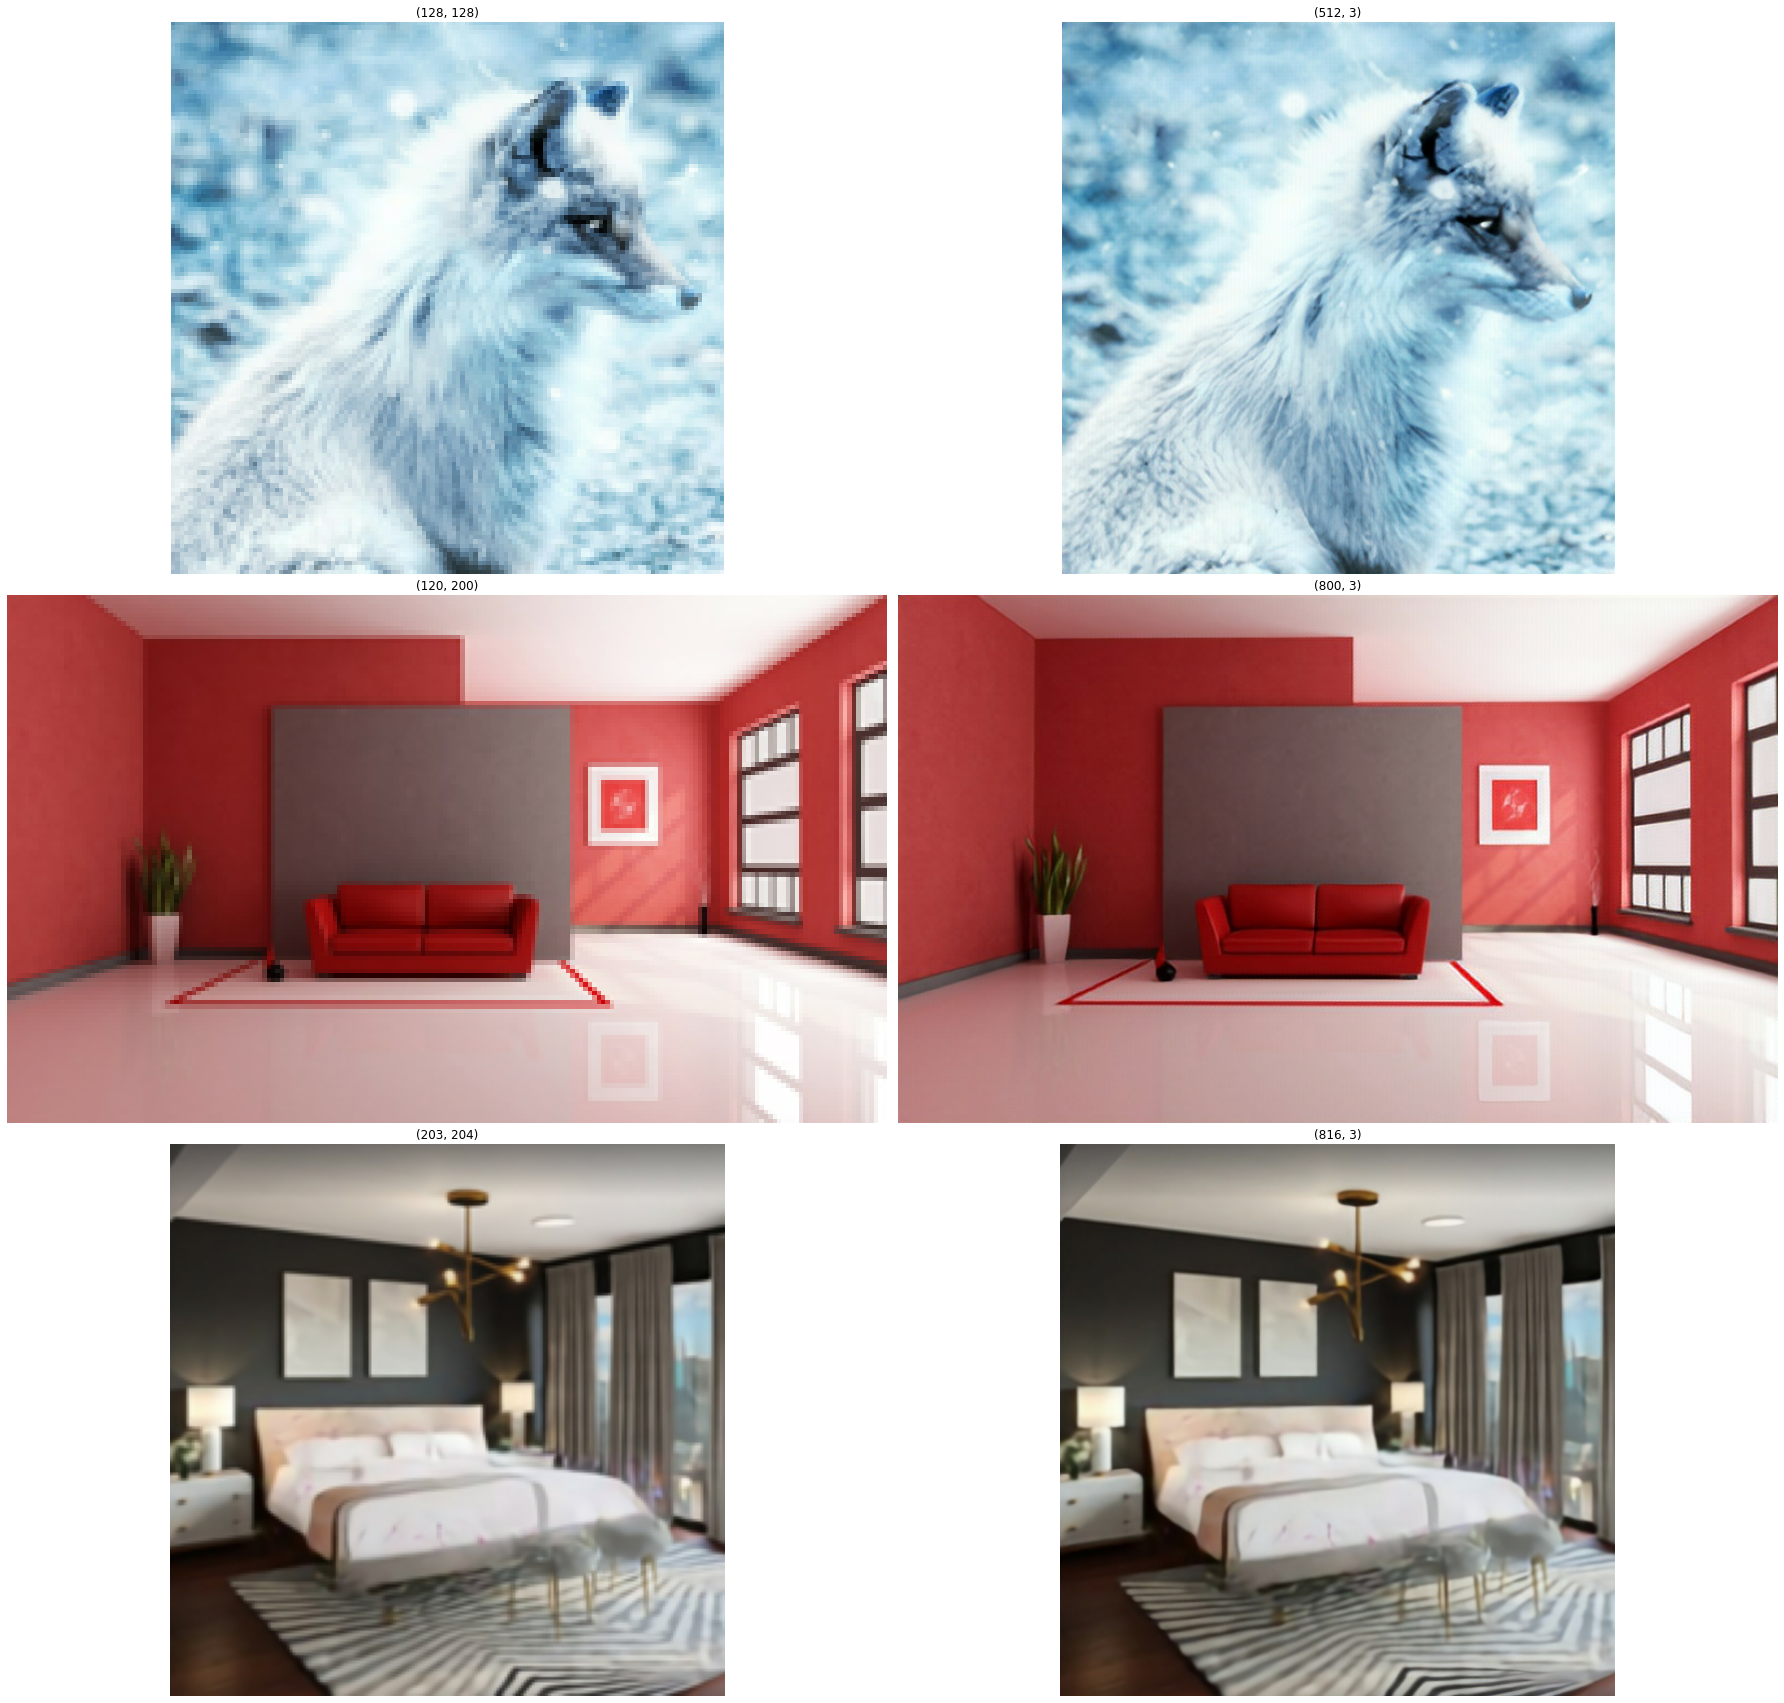

In [3]:
import os
import time
from PIL import Image
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

def preprocess_image(image_path):
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
      # If PNG, remove the alpha channel. The model only supports
      # images with 3 color channels.
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)
    
    
def plot_image(image, title=""):
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)


# Defining helper functions
def downscale_image(image):
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(
    tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

    lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))

    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

model = hub.load(SAVED_MODEL_PATH)
plt.rcParams['figure.figsize'] = [25, 8 * len(img_paths)]
fig, axes = plt.subplots(len(img_paths),2)

lr_img, super_img = [],[]
for i in range(len(img_paths)):
    IMAGE_PATH=img_paths[i]
    hr_image=hr_image = preprocess_image(IMAGE_PATH)
    lr_image = downscale_image(tf.squeeze(hr_image))
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)
    lr_img.append(lr_image)
    super_img.append(fake_image)
    plt.subplot(len(img_paths),2,2*i+1)
    fig.tight_layout()
    plot_image(tf.squeeze(lr_image), str(lr_image.shape[1:3]))
    plt.subplot(len(img_paths),2,2*i+2)
    fig.tight_layout()
    plot_image(tf.squeeze(fake_image), str(fake_image.shape[1:3]))

In [4]:
super_img

[<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
 array([[[ 64.96089,  91.47341, 121.36587],
         [ 90.25726, 128.86826, 162.28313],
         [ 96.25488, 140.60841, 168.38258],
         ...,
         [156.67172, 189.77368, 207.91968],
         [155.99069, 194.7737 , 210.66231],
         [157.8572 , 189.54509, 204.69717]],
 
        [[ 97.24036, 133.67784, 172.1736 ],
         [ 95.83415, 131.54837, 169.26793],
         [ 92.57768, 143.07402, 169.42268],
         ...,
         [155.65298, 201.2527 , 218.15996],
         [164.55069, 207.20021, 212.3294 ],
         [159.8142 , 209.52562, 197.60373]],
 
        [[ 98.42425, 134.88234, 167.28804],
         [ 93.6587 , 140.4714 , 180.09587],
         [ 98.89869, 146.50758, 173.19414],
         ...,
         [145.6823 , 200.7989 , 226.03407],
         [156.47778, 204.75269, 216.57869],
         [148.3462 , 197.7506 , 200.43593]],
 
        ...,
 
        [[154.617  , 180.09555, 194.42265],
         [167.62216, 190.24992, 203.53091]